# Analysis of NYC Public Schools SHSAT Data

This is a review of the registration and completion data for the SHSAT test.  The Specialized high school admissions test (SHSAT) is used for placement in NYC Specialized Schools.  Students are ranked according to their score on the test and assigned to a school depending on their rank, the priority in which they placed schools on their application, and the seats available at each school. 

The goal of this analyis is to identify and propose a research project that will raise the rates of SHSAT test-taking.

## Background

### SHSAT [link](https://www.schools.nyc.gov/school-life/learning/testing/specialized-high-school-admissions-test)

The SHSAT assesses knowledge and skills. These skills consist of the ability to comprehend English prose, to demonstrate understanding of revising and editing skills central to writing in English, and to use problem-solving skills in mathematics. The test measures knowledge and skills students have gained over the course of their education. 

### NYC Specialized High Schools [link](https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City)

The specialized high schools of New York City are nine selective public high schools, established and run by the New York City Department of Education to serve the needs of academically and artistically gifted students.

### PASSNYC [link](http://www.passnyc.org/opportunity)

Roughly a third of the 8th graders applying to the City's public high schools sit for the SHSAT, with only 6% (5,000 students) receiving admission offers. The vast majority of these go to students from "feeder" schools that represent less than one fifth of the total number of middle schools in the City.

Promoting Access to Specialized Schools in New York City ("PASSNYC") will focus our efforts in underperforming areas that are historically underrepresented in SHSAT registration. In so doing, PASSNYC will help pave the path to specialized high schools for a more diverse group of students.

### District 5 & SHSAT Registration, Take, and Skip Rates

PASSNYC published an example dataset for district 5 (bronx) for 2013-16.  There are 30 schools in that district with students eligible for the SHSAT, and between 314-351 students from the district took the test each year.  

While most schools in the district have 50-120 students, most schools have fewer than 30 SHSAT registrants and fewer than 15 SHSAT takers.  As registration rate rises, skip rate also rises - i.e. schools with a higher percentage of registrants also see a greater percentage of those registrants fail to actually take the test. Despite this "skip-effect", higher registration rates still co-occur with higher take-rates. 

Several school characteristics appear to correlate (p >0.12) with test-taking behavior: 
* racial make-up
* % of students learning english as a second language
* % trust
* % collaborative teaching
* % effective leadership
* % supportive environment   


In [1]:
#imports and data load
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
#import psid_py as psid
%matplotlib inline

shsat = pd.read_csv("SHSAT_Registrations_and_Testers.csv")
schools = pd.read_csv("2016_School_Explorer.csv")

In [ ]:
#data cleaning

#add registration, take and skip rate columns
shsat["reg_rate"] = (shsat["Number of students who registered for the SHSAT"] / 
                      shsat["Enrollment on 10/31"] )
shsat["take_rate"] = (shsat["Number of students who took the SHSAT"] / 
                      shsat["Enrollment on 10/31"] )
shsat["skip_rate"] = (1- (shsat["Number of students who took the SHSAT"] / 
                      shsat["Number of students who registered for the SHSAT"]))

#sort shsat by take rate
shsat[shsat.reg_rate>.9].sort_values("take_rate", ascending=False)

#remove spaces 
schools.columns.str.replace(' ','')

In [166]:
#number of schools in district 5
len(shsat["School name"].unique())

30

In [200]:
# of eligible studens / year
takers_by_year = shsat[["Number of students who took the SHSAT", "Year of SHST"]].groupby("Year of SHST").sum().reset_index()
eligible_by_year = shsat[["Enrollment on 10/31", "Year of SHST"]].groupby("Year of SHST").sum().reset_index()
overall_take_rates = pd.merge(left=eligible_by_year, right=takers_by_year, on="Year of SHST")
overall_take_rates["take_rate"] = overall_take_rates["Number of students who took the SHSAT"]  \
                                  / overall_take_rates["Enrollment on 10/31"]
overall_take_rates

,Year of SHST,Enrollment on 10/31,Number of students who took the SHSAT,take_rate
0,2013,3109,314,0.100997
1,2014,3243,347,0.107000
2,2015,3164,341,0.107775
3,2016,3360,351,0.104464


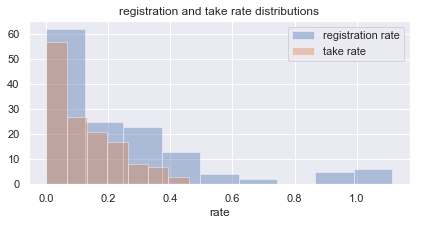

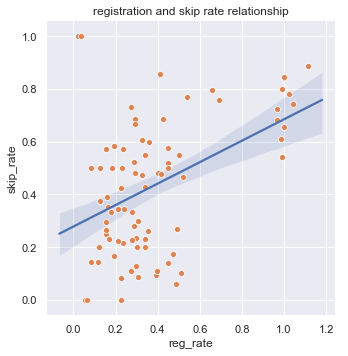

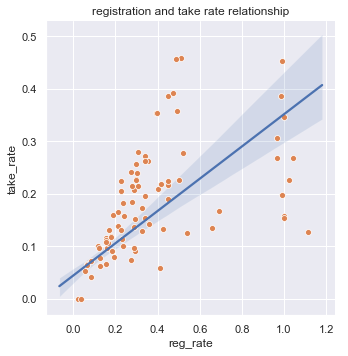

In [209]:
#distribution of, relationship bw, registration & take rates

sns.set()
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1, title = "registration and take rate distributions")
sns.distplot(shsat.reg_rate, kde=False)
sns.distplot(shsat.take_rate, kde=False)
plt.legend(["registration rate", "take rate"])
plt.xlabel("rate")

ax2 = sns.lmplot(x="reg_rate", y="skip_rate", data=shsat, scatter=False)
ax2 = sns.scatterplot(x="reg_rate", y="skip_rate", data=shsat[shsat["Grade level"]==8])
plt.title("registration and skip rate relationship")
plt.show()

ax2 = sns.lmplot(x="reg_rate", y="take_rate", data=shsat, scatter=False)
ax2 = sns.scatterplot(x="reg_rate", y="take_rate", data=shsat[shsat["Grade level"]==8])
plt.title("registration and take rate relationship")
plt.show()


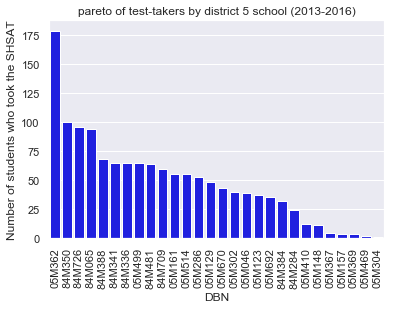

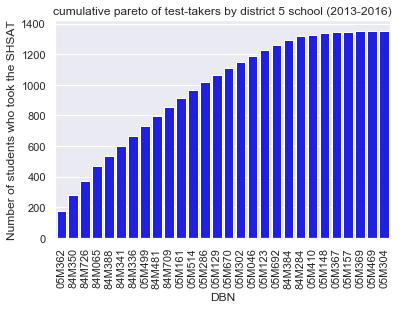

In [187]:
#pareto of test-takers by school
sorted_takers = shsat[["DBN","Number of students who took the SHSAT"]]\
    .groupby("DBN", as_index=False).sum()\
    .sort_values("Number of students who took the SHSAT", ascending=False)

sns.barplot(x="DBN", y="Number of students who took the SHSAT", data=sorted_takers, color="blue")
plt.xticks(rotation=90)
plt.title("pareto of test-takers by district 5 school (2013-2016)")
plt.show()

#cumulative pareto of test-takers by school
sns.barplot(x=sorted_takers["DBN"], y=sorted_takers["Number of students who took the SHSAT"].cumsum(), color="blue")
plt.xticks(rotation=90)
plt.title("cumulative pareto of test-takers by district 5 school (2013-2016)")
plt.show()


In [191]:
#merging to get at school demographic data
schools["name"] = schools["School Name"].str.strip().str.replace(" ", "").str.upper()
shsat["name"] = shsat["School name"].str.strip().str.replace(" ", "").str.upper()


d5 = shsat.merge(right=schools, how="left", on="name", indicator=True)

print("# of district 5 schools not present in schools data:  ",  \
      len(d5[d5["_merge"] == "left_only"]["name"].unique()))
print("average sum of students / year taking the test in all excluded schools:  ", \
      d5[["name", "Year of SHST", "Number of students who took the SHSAT"]]\
      [d5["_merge"] == "left_only"]\
          .groupby(["Year of SHST"]).sum().reset_index()["Number of students who took the SHSAT"].mean())




# of district 5 schools not present in schools data:   9
average sum of students / year taking the test in all excluded schools:   22.0


In [208]:
#further data prep to enable boxplots and t-tests

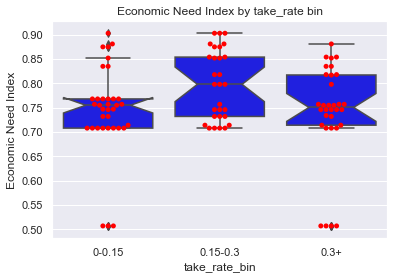

Ttest_indResult(statistic=-2.6749803270877055, pvalue=0.021729528507068455)


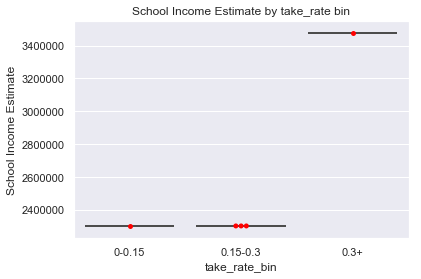

Ttest_indResult(statistic=masked, pvalue=masked_array(data=--,
             mask=True,
       fill_value=1e+20,
            dtype=float64))


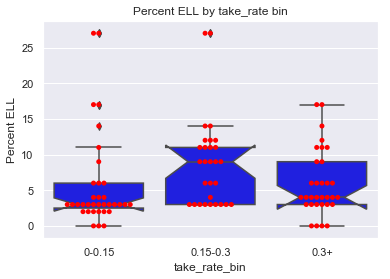

Ttest_indResult(statistic=-3.453047015645117, pvalue=0.0023840556320731347)


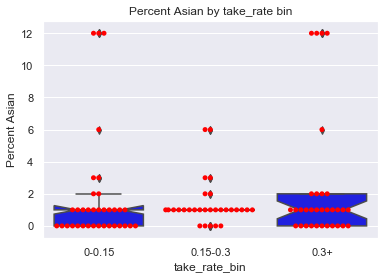

Ttest_indResult(statistic=1.9341156493179719, pvalue=0.08065472801355711)


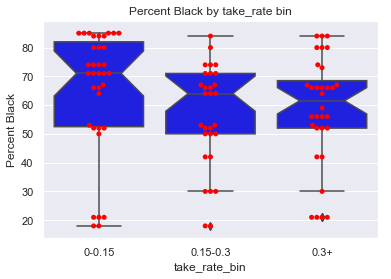

Ttest_indResult(statistic=-1.7420905661951633, pvalue=0.10799546466320961)


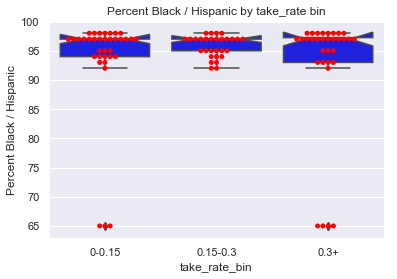

Ttest_indResult(statistic=-1.943811629825334, pvalue=0.07958253338664567)


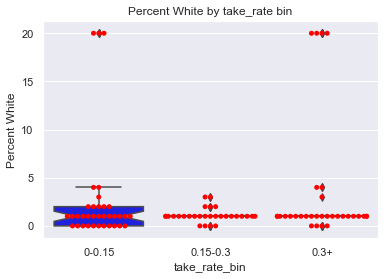

Ttest_indResult(statistic=2.088638999083116, pvalue=0.06231196404764243)


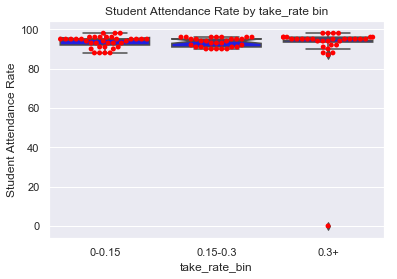

Ttest_indResult(statistic=-0.7032426796573972, pvalue=0.49792143475232387)


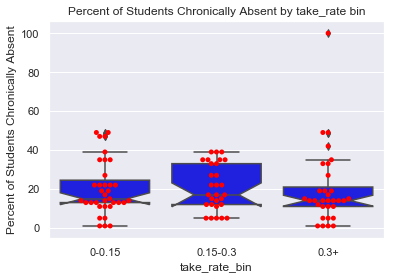

Ttest_indResult(statistic=-0.40464183301459894, pvalue=0.6939004253521255)


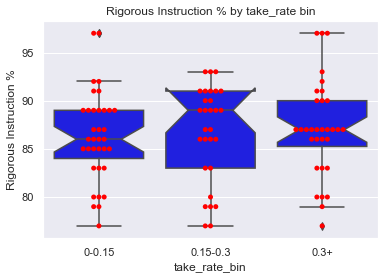

Ttest_indResult(statistic=0.6448026807860106, pvalue=0.529690271769607)


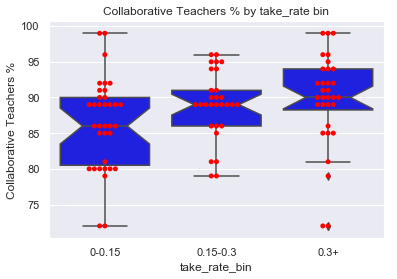

Ttest_indResult(statistic=3.8303872522284776, pvalue=0.0008586282943420005)


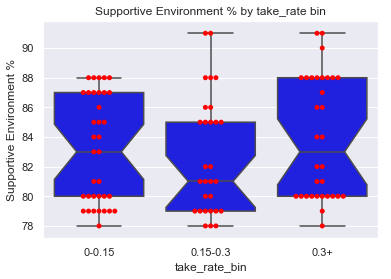

Ttest_indResult(statistic=1.6535363057368915, pvalue=0.12447145491497638)


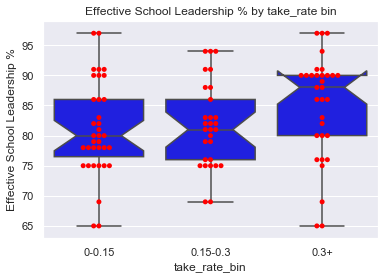

Ttest_indResult(statistic=6.908596283469333, pvalue=4.803006118591228e-08)


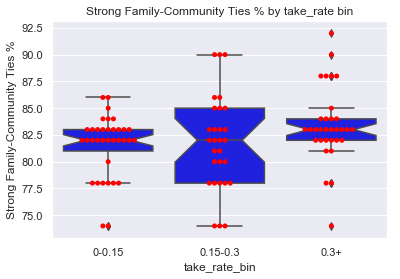

Ttest_indResult(statistic=3.497332357306362, pvalue=0.0037677723822063668)


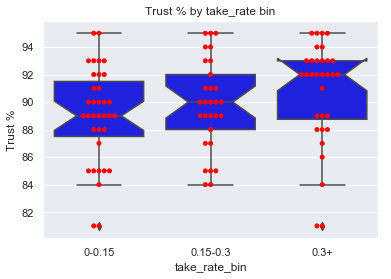

Ttest_indResult(statistic=6.806743260593638, pvalue=1.3930972322412264e-08)


In [207]:
#box plots and t-tests:  what school characteristics vary with test-taking behavior?

columns_of_interest = ["Economic Need Index", "School Income Estimate",
                      "Percent ELL", "Percent Asian", "Percent Black", 
                      "Percent Black / Hispanic", "Percent White", 
                      "Student Attendance Rate","Percent of Students Chronically Absent",
                      "Rigorous Instruction %", 
                      "Collaborative Teachers %", "Supportive Environment %", 
                       "Effective School Leadership %", "Strong Family-Community Ties %", 
                      "Trust %"]

#adds prints box-plot of a given continuous numeric column for each take-rate bin
def box_take_rate(compare_column):
    ax1 = sns.boxplot(x="take_rate_bin", y=compare_column, data=d5, notch=True, color="blue")
    ax1 = sns.swarmplot(x="take_rate_bin", y=compare_column, data=d5, color = "red")
    plt.title(compare_column + " by take_rate bin")
    plt.show()
    
    from scipy.stats import ttest_ind

    greater_than_3 = d5[d5.take_rate >= 0.3][compare_column]
    less_than_3 = d5[d5.take_rate < 0.3][compare_column]

    print(ttest_ind(greater_than_3, less_than_3, equal_var=False, nan_policy='omit'))
    
for col in columns_of_interest: box_take_rate(col)

## Research Proposal

### Problem 
Less then 11% of eligible students are registering for and taking the SHSAT.  We need to improve the registration and take rates to ensure the most talented students are recruited into these powerful educational programs. 

### Potential Solution
The current process to register for the SHSAT is "opt-in" - i.e. students are registered if they take the initiative to proactively register.  One potential solution to low registration and take rates are to change to an opt-out process. I hypothesize that an opt-out process will improve both registration and take rates as compared to the current opt-in process. 

### Method
*Sampling & Group Assignment:*  

All schools in the city will be divided into cohorts based on similarities in the school characteristices (see "District 5 & SHSAT Registration, Take, and Skip Rates" above) that correlate with test-taking behavior.  

Each school in each cohort will be randomly assigned to one of two treatment groups: the control group receiving the current opt-in treatment, and the test group receiving the new opt-out treatment.  Half of all schools in each cohort will be in the test group. 

*Treatment:* 

All students in 8th grade in the both gropus will receive a take-home slip indicating their enrollment status in the test.  The form will include the ability to reverse their status.  Other than the option ("registered," "not registered") the two slips will be as much the same as is possible while being coherent.  If the slip is not returned the default option will remain in force.  

All registerd students will receive the same treatment leading up to the test (reminders, instructions, etc.) and on the test day itself.  

*Data Collection: * 

These variables will be collected (in addition to the school-level group assignment variables listed above): 
* school
* final registration status (post slip return)
* race
* date of birth
* test-taker status
* test result (accepted to school or not)
* matriculation status (attended first day at special school or not)

### Evaluation Plan

For each of the cohorts (see group assignment above) the null hypothesis will be rejected if the test-taking rate of the test group exceeds the rate of the control group (p < 0.05).   If the null hypothesis is rejected, then a move to a broad opt-out program for the test will be proposed to the city school board.  

In addition, I will compare test result and matriculation rates between the two groups.  It's possible that those "nudged" into taking the test may be less likely to pass the test and/or matriculate.  Improving test-taking rates are worthwhile in any case, but this data may prove useful in identifying the need for further intervention lower in the funnel.

A follow-up study will be conducted in five years to compare graduation rates across the two groups.